To do:
- explain reasoning behind plotting all points versus daily sums
- write about analyzing all sensors together versus each independently in step 4

In [472]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import statsmodels.api as sm
import matplotlib.pylab as pl
import statsmodels.formula.api as smf
import zipfile
import os

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# 1. Clean and plot the data for the individual sensors provided

In [327]:
data = pd.read_csv('LuxDustNoise_summarized_4hour_0719.csv', parse_dates=True)
data.index = data['dt']
data.rename(columns={'con':'particles', 'spl':'sound', 'lux':'light'}, inplace=True)
data.index = pd.to_datetime(data.index)
data.head()

,dt,sensor,light,particles,sound
dt,,,,,
2016-06-21 00:00:00,2016-06-21 00:00:00,sensor_0,0.0,2834.03125,66.308479
2016-06-21 00:00:00,2016-06-21 00:00:00,sensor_2,0.0,1691.99625,70.375943
2016-06-21 00:00:00,2016-06-21 00:00:00,sensor_3,0.0,1686.44125,76.235738
2016-06-21 00:00:00,2016-06-21 00:00:00,sensor_4,0.0,2324.65875,70.652334
2016-06-21 04:00:00,2016-06-21 04:00:00,sensor_0,3213.5,2748.28875,81.467436


dt = date and time

lux = luminosity

con  = particle count per 0.01 cubic feet

spl = sound pressure level in dB

#### sensor_0 : RHI roof (at corner of Hicks and W 9th streets, elevation approx. 8m) - 767 Hicks St, Brooklyn, NY 11231
#### sensor_3 : RHI entrance (on Hicks street at street level) - 767 Hicks St, Brooklyn, NY 11231
#### sensor_2 : TechLab (at ground level) - 106 Ferris St, Brooklyn, NY 11231
#### sensor_4 : PioneerWorks roof (elevation approx. 15m) - 159 Pioneer St, Brooklyn, NY 11231

In [73]:
data['address'] = 0

In [74]:
# adding a column for address (not sure if/how I'll use this)
data['address'][data.sensor == 'sensor_0'] = "767 Hicks St, Brooklyn, NY 11231"
data['address'][data.sensor == 'sensor_3'] = "767 Hicks St, Brooklyn, NY 11231"
data['address'][data.sensor == 'sensor_2'] = "106 Ferris St, Brooklyn, NY 11231"
data['address'][data.sensor == 'sensor_4'] = "159 Pioneer St, Brooklyn, NY 11231"

data.head()

/Users/adriandahlin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,sensor,light,particles,sound,address
dt,,,,,
2016-06-21 00:00:00,sensor_0,0.0,2834.03125,66.308479,"767 Hicks St, Brooklyn, NY 11231"
2016-06-21 00:00:00,sensor_2,0.0,1691.99625,70.375943,"106 Ferris St, Brooklyn, NY 11231"
2016-06-21 00:00:00,sensor_3,0.0,1686.44125,76.235738,"767 Hicks St, Brooklyn, NY 11231"
2016-06-21 00:00:00,sensor_4,0.0,2324.65875,70.652334,"159 Pioneer St, Brooklyn, NY 11231"
2016-06-21 04:00:00,sensor_0,3213.5,2748.28875,81.467436,"767 Hicks St, Brooklyn, NY 11231"


In [331]:
# creating a dataframe for each sensor (these were poorly named spl even though they're more than just spl,
# but I'm leaving it as is since so much was done with them below; would come back and change it later).
spl_0 = data[data['sensor'] == 'sensor_0']
spl_2 = data[data['sensor'] == 'sensor_2']
spl_3 = data[data['sensor'] == 'sensor_3']
spl_4 = data[data['sensor'] == 'sensor_4']

In [332]:
# creating a dataframe for each sensor and summing (averaging might be better) for each day
spl_0_daily = data[data['sensor'] == 'sensor_0'].resample('d').sum()
spl_2_daily = data[data['sensor'] == 'sensor_2'].resample('d').sum()
spl_3_daily = data[data['sensor'] == 'sensor_3'].resample('d').sum()
spl_4_daily = data[data['sensor'] == 'sensor_4'].resample('d').sum()

In [333]:
spl_0.head()

,dt,sensor,light,particles,sound
dt,,,,,
2016-06-21 00:00:00,2016-06-21 00:00:00,sensor_0,0.000,2834.03125,66.308479
2016-06-21 04:00:00,2016-06-21 04:00:00,sensor_0,3213.500,2748.28875,81.467436
2016-06-21 08:00:00,2016-06-21 08:00:00,sensor_0,24532.625,2720.35125,80.020600
2016-06-21 12:00:00,2016-06-21 12:00:00,sensor_0,40268.250,2443.72875,76.525876
2016-06-21 16:00:00,2016-06-21 16:00:00,sensor_0,17189.750,2717.49625,80.020600


In [231]:
# function to plot one data source for each sensor
def plot_all_points(column):
    if column == 'light':
        ylabel = 'luminosity'
    if column == 'particles':
        ylabel = 'particle count per 0.01 cubic feet'
    if column == 'sound':
        ylabel = 'sound pressure level in dB'
    
    fig = pl.figure(figsize=(12, 6))
    
    # making the y range the same for all subplots
    maxes = (spl_0[column].max(), spl_2[column].max(), spl_3[column].max(), spl_4[column].max())
    ymax = max(maxes) * 1.03
    mins = (spl_0[column].min(), spl_2[column].min(), spl_3[column].min(), spl_4[column].min())
    ymin = min(mins) - ymax/100
    
    sub1 = fig.add_subplot(221)
    sub1.plot(spl_0[column])
    sub1.set_title('All ' + column + ' readings from RHI roof', color='blue', fontsize=14)
    sub1.set_ylabel(ylabel)
    sub1.set_ylim(ymin, ymax)
    sub2 = fig.add_subplot(222)
    sub2.plot(spl_2[column], 'r')
    sub2.set_title('All ' + column + ' readings from TechLab (ground level)', color='red', fontsize=14)
    sub2.set_ylim(ymin, ymax)
    sub3 = fig.add_subplot(223)
    sub3.plot(spl_3[column], 'g')
    sub3.set_title('All ' + column + ' readings from RHI entrance', color='green', fontsize=14)
    sub3.set_xlabel('Readings every four hours')
    sub3.set_ylabel(ylabel)
    sub3.set_ylim(ymin, ymax)
    sub4 = fig.add_subplot(224)
    sub4.plot(spl_4[column], 'purple')
    sub4.set_title('All ' + column + ' readings from PioneerWorks roof', color='purple', fontsize=14)
    sub4.set_xlabel('Readings every four hours')
    sub4.set_ylim(ymin, ymax)
    
    fig.autofmt_xdate()
    fig.tight_layout()

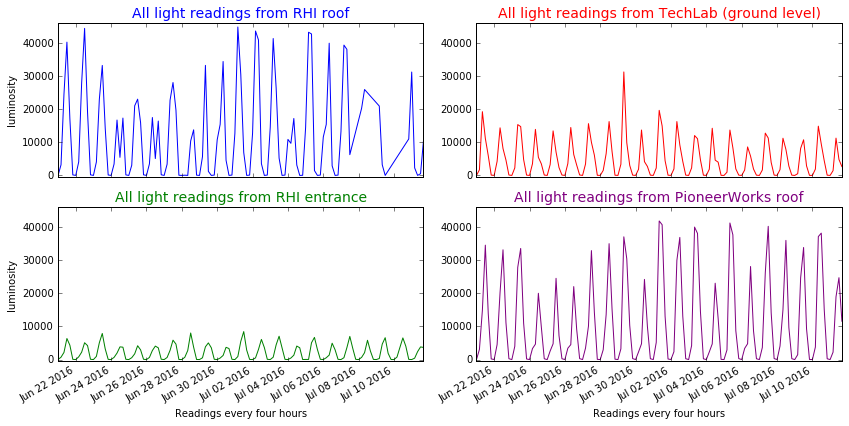

In [232]:
plot_all_points('light')

Fig. 1 Shows all light sensor data split by sensor location.

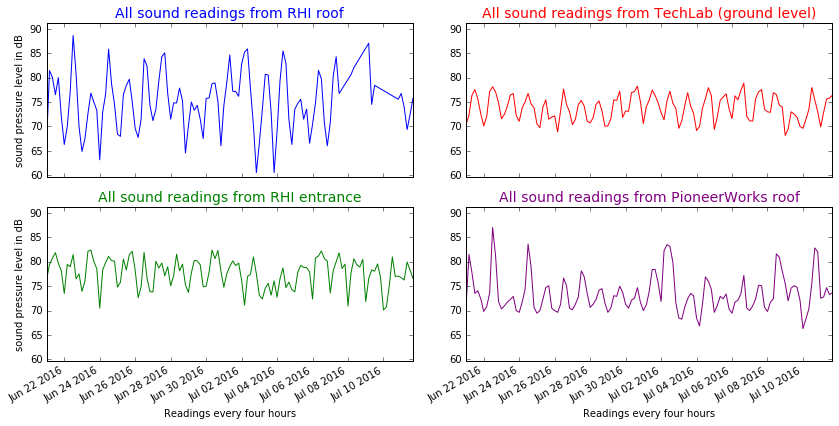

In [233]:
plot_all_points('sound')

Fig. 2 Shows all sound data split by sensor location.

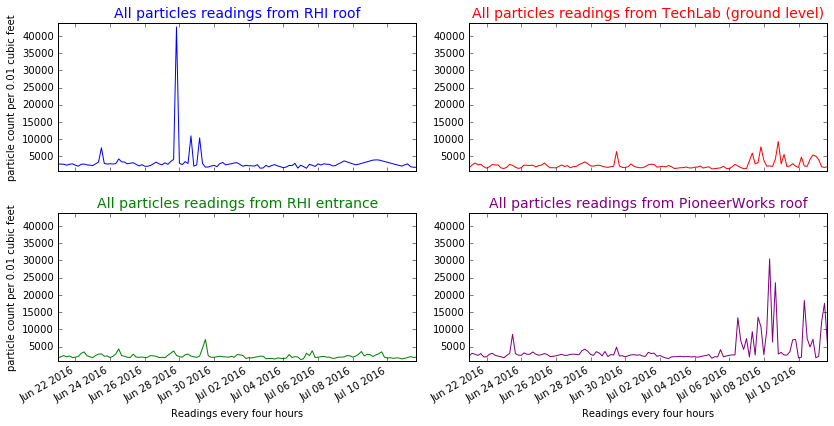

In [234]:
plot_all_points('particles')

Fig 3. Shows all air quality data, split by sensor location.

In [241]:
# defining a function to plot one data source for each sensor, aggregated by day (didn't end up using this in analysis)
def plot_daily_points(column):
    if column == 'light':
        ylabel = 'luminosity'
    if column == 'particles':
        ylabel = 'particle count per 0.01 cubic feet'
    if column == 'sound':
        ylabel = 'sound pressure level in dB'
    
    fig = pl.figure(figsize=(12, 6))
    
    # making the y range the same for all subplots
    maxes = (spl_0_daily[column].max(), spl_2_daily[column].max(), spl_3_daily[column].max(), spl_4_daily[column].max())
    ymax = max(maxes) * 1.03
    mins = (spl_0_daily[column].min(), spl_2_daily[column].min(), spl_3_daily[column].min(), spl_4_daily[column].min())
    ymin = min(mins) - ymax/100
    
    sub1 = fig.add_subplot(221)
    sub1.plot(spl_0_daily[column])
    sub1.set_title('Daily ' + column + ' reading from RHI roof', color='blue', fontsize=14)
    sub1.set_ylabel(ylabel)
    sub1.set_ylim(ymin, ymax)
    sub2 = fig.add_subplot(222)
    sub2.plot(spl_2_daily[column], 'r')
    sub2.set_title('Daily ' + column + ' reading from TechLab (ground level)', color='red', fontsize=14)
    sub2.set_ylim(ymin, ymax)
    sub3 = fig.add_subplot(223)
    sub3.plot(spl_3_daily[column], 'g')
    sub3.set_title('Daily ' + column + ' reading from RHI entrance', color='green', fontsize=14)
    sub3.set_xlabel('Readings for every day')
    sub3.set_ylabel(ylabel)
    sub3.set_ylim(ymin, ymax)
    sub4 = fig.add_subplot(224)
    sub4.plot(spl_4_daily[column], 'purple')
    sub4.set_title('Daily ' + column + ' reading from PioneerWorks roof', color='purple', fontsize=14)
    sub4.set_xlabel('Readings for every day')
    sub4.set_ylim(ymin, ymax)
    
    fig.autofmt_xdate()
    fig.tight_layout()

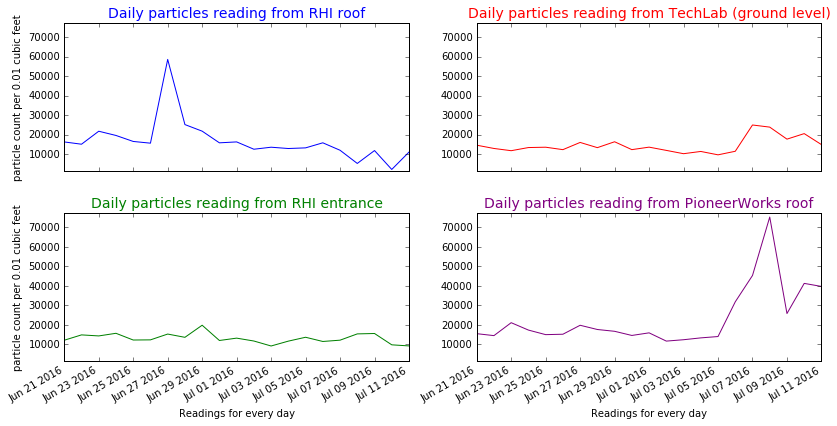

In [242]:
plot_daily_points('particles')

Fig. 4 Shows air quality data aggregated (summed) by day.

# 2. Describe the daily patterns that emerge

Light and sound have very regular daily cycles with high values during the day and lower values (for sound) or essentially zero (for light) during the evening.

It's harder to observe daily patterns for air particulates because of the outliers (especially on the roofs).

In [477]:
# function to delete outliers from data and plot to observe daily patterns better
def plot_reduced_points(column):
    if column == 'light':
        ylabel = 'luminosity'
    if column == 'particles':
        ylabel = 'particle count per 0.01 cubic feet'
    if column == 'sound':
        ylabel = 'sound pressure level in dB'
    
    fig = pl.figure(figsize=(16, 8))
    
    # removing upper outliers
    std0 = spl_0[column].std()
    mean0 = spl_0[column].mean()
    reduced0 = spl_0[spl_0[column] < (mean0 + 2 * std0)]
    
    std2 = spl_2[column].std()
    mean2 = spl_2[column].mean()
    reduced2 = spl_2[spl_2[column] < (mean0 + 2 * std0)]
    
    std3 = spl_3[column].std()
    mean3 = spl_3[column].mean()
    reduced3 = spl_3[spl_3[column] < (mean0 + 2 * std0)]
    
    std4 = spl_4[column].std()
    mean4 = spl_4[column].mean()
    reduced4 = spl_4[spl_4[column] < (mean0 + 2 * std0)]
    
    # making the y range the same for all subplots
    maxes = (reduced0[column].max(), reduced2[column].max(), reduced3[column].max(), reduced4[column].max())
    ymax = max(maxes) * 1.03
    mins = (reduced0[column].min(), reduced2[column].min(), reduced3[column].min(), reduced4[column].min())
    ymin = min(mins) - ymax/100
    
    sub1 = fig.add_subplot(221)
    sub1.plot(reduced0[column])
    sub1.set_title('Reduced ' + column + ' readings from RHI roof', color='blue', fontsize=14)
    sub1.set_ylabel(ylabel)
    sub1.set_ylim(ymin, ymax)
    sub2 = fig.add_subplot(222)
    sub2.plot(reduced2[column], 'r')
    sub2.set_title('Reduced ' + column + ' readings from TechLab (ground level)', color='red', fontsize=14)
    sub2.set_ylim(ymin, ymax)
    sub3 = fig.add_subplot(223)
    sub3.plot(reduced3[column], 'g')
    sub3.set_title('Reduced ' + column + ' readings from RHI entrance', color='green', fontsize=14)
    sub3.set_xlabel('Readings every four hours')
    sub3.set_ylabel(ylabel)
    sub3.set_ylim(ymin, ymax)
    sub4 = fig.add_subplot(224)
    sub4.plot(reduced4[column], 'purple')
    sub4.set_title('Reduced ' + column + ' readings from PioneerWorks roof', color='purple', fontsize=14)
    sub4.set_xlabel('Readings every four hours')
    sub4.set_ylim(ymin, ymax)
    
    fig.autofmt_xdate()
    fig.tight_layout()

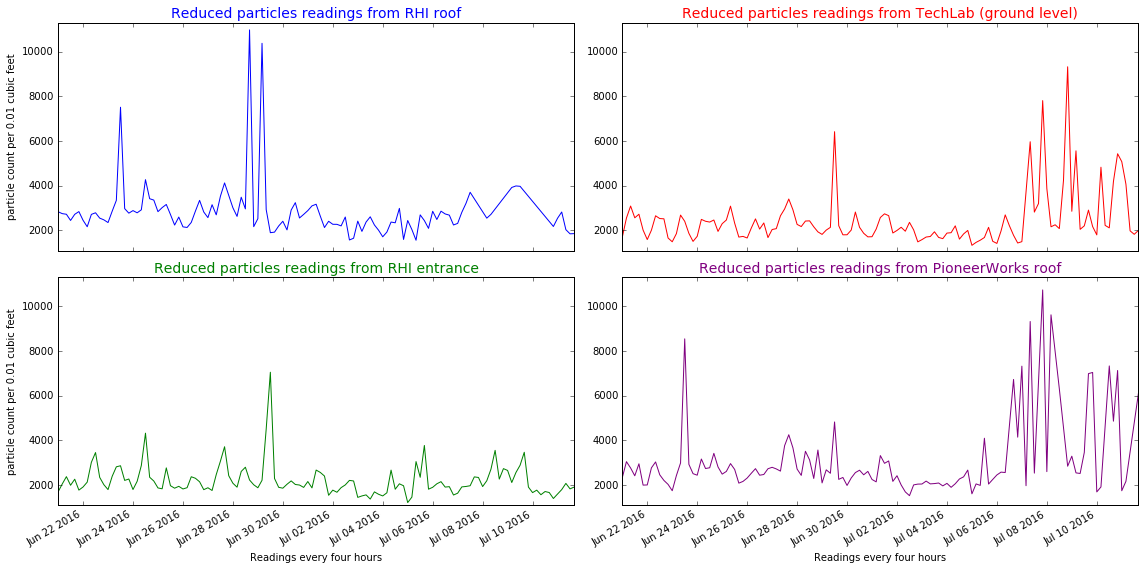

In [478]:
plot_reduced_points('particles')

Fig. 5 Shows all particulate data for all sensor locations, with values more than two std above the mean removed. This shows the daily cycle a bit more, although there's still lots of variance. Particulate matter appears to go down at night (look at the tic marks, which are presumably at midnight each day).

# 3. Identify anomalous activity

## Focusing on anomalies pertaining to questions asked in next section.

Referencing Fig 5: RHI saw spikes on June 27 (massive spike, roof only) and 29 (much smaller spike, ground and roof levels). Something clearly happened these two days, unless the rooftop sensor malfunctioned on June 27. TechLab and PioneerWorks both had a sustained jump in particulates between July 7 and 12. These two locations are toward the west, closer to the water than RHI, and less than .5 mile apart. They may have been affected by an event in their vacinity or by a larger effect coming from being near the water.

In [432]:
# find highest noise times to later compare with noise complaints
def calcOutliers(sensor, column):
    mean = sensor[column].mean()
    std = sensor[column].std()
    UpperLimit = mean + 2 * std
    LowerLimit = mean - 2 * std
    name =[x for x in globals() if globals()[x] is sensor][0]
    print 'mean', column, 'for %s is:' % name, mean
    print 'upper limit:', UpperLimit
    print 'lower limit:', LowerLimit
    UpperOutliers = pd.DataFrame()
    LowerOutliers = pd.DataFrame()
    UpperOutliers = sensor[sensor[column] > UpperLimit]
    LowerOutliers = sensor[sensor[column] < LowerLimit]
    #outliers = UpperOutliers + LowerOutliers
    print UpperOutliers
    print LowerOutliers

In [433]:
# calculating sound outliers from sensor 0 (RHI roof)
calcOutliers(spl_0, 'sound')

mean sound for spl_0 is: 75.0982318452
upper limit: 87.0070261792
lower limit: 63.1894375112
                                      dt    sensor      light   particles  \
dt                                                                          
2016-06-22 12:00:00  2016-06-22 12:00:00  sensor_0  44426.625  2786.37125   
2016-07-09 04:00:00  2016-07-09 04:00:00  sensor_0  20956.000  3919.89000   

                         sound  
dt                              
2016-06-22 12:00:00  88.647875  
2016-07-09 04:00:00  87.064250  
                                      dt    sensor    light   particles  \
dt                                                                        
2016-06-24 00:00:00  2016-06-24 00:00:00  sensor_0    0.000  2883.73500   
2016-07-02 20:00:00  2016-07-02 20:00:00  sensor_0  106.000  1647.84875   
2016-07-03 20:00:00  2016-07-03 20:00:00  sensor_0  100.875  2005.82750   

                         sound  
dt                              
2016-06-24 00:00:00  63.

In [427]:
# calculating sound outliers from sensor 2 (TechLab)
calcOutliers(spl_2, 'sound')

mean sound for spl_2 is: 73.7969831213
upper limit: 78.9447007696
lower limit: 68.6492654729
Empty DataFrame
Columns: [dt, sensor, light, particles, sound]
Index: []
                             dt    sensor  light  particles      sound
dt                                                                    
2016-07-09  2016-07-09 00:00:00  sensor_2    0.0  2853.9675  68.165612


In [428]:
# calculating sound outliers from sensor 3 (RHI entrance)
calcOutliers(spl_3, 'sound')

mean sound for spl_3 is: 77.6560980453
upper limit: 83.6283784814
lower limit: 71.6838176092
Empty DataFrame
Columns: [dt, sensor, light, particles, sound]
Index: []
                                      dt    sensor   light   particles  \
dt                                                                       
2016-06-24 00:00:00  2016-06-24 00:00:00  sensor_3    0.00  1794.35625   
2016-07-02 04:00:00  2016-07-02 04:00:00  sensor_3  497.75  1671.99750   
2016-07-08 00:00:00  2016-07-08 00:00:00  sensor_3    0.00  1926.61500   
2016-07-10 00:00:00  2016-07-10 00:00:00  sensor_3    0.00  1656.01875   
2016-07-10 04:00:00  2016-07-10 04:00:00  sensor_3  743.50  1766.47250   

                         sound  
dt                              
2016-06-24 00:00:00  70.472973  
2016-07-02 04:00:00  71.107221  
2016-07-08 00:00:00  70.941357  
2016-07-10 00:00:00  70.107231  
2016-07-10 04:00:00  70.758345  


In [429]:
# calculating sound outliers from sensor 4 (PioneerWorks roof)
calcOutliers(spl_4, 'sound')

mean sound for spl_4 is: 73.4395930082
upper limit: 81.1669330142
lower limit: 65.7122530022
                                      dt    sensor      light   particles  \
dt                                                                          
2016-06-21 04:00:00  2016-06-21 04:00:00  sensor_4   3057.750  3041.73875   
2016-06-22 12:00:00  2016-06-22 12:00:00  sensor_4  33164.750  2453.33875   
2016-06-22 16:00:00  2016-06-22 16:00:00  sensor_4  11140.125  2202.26500   
2016-06-24 12:00:00  2016-06-24 12:00:00  sensor_4  20026.250  2768.51750   
2016-07-02 04:00:00  2016-07-02 04:00:00  sensor_4   2357.625  1999.06250   
2016-07-02 08:00:00  2016-07-02 08:00:00  sensor_4  29966.875  1687.49625   
2016-07-02 12:00:00  2016-07-02 12:00:00  sensor_4  36907.125  1519.16750   
2016-07-08 12:00:00  2016-07-08 12:00:00  sensor_4  36006.875  6300.91000   
2016-07-10 16:00:00  2016-07-10 16:00:00  sensor_4  15162.250  4852.13250   
2016-07-10 20:00:00  2016-07-10 20:00:00  sensor_4    238.00

Chose to define outliers as 2 standard deviations away from the mean. 3 std produced only one outlier in sensor 4 and no outliers for the rest. 2 std produced several outliers for each sensor, though sensors 2 and 3 (at street level) had only small outliers, not large ones (see "Empty DataFrame"). PioneerWorks roof has many upper outliers at many times of day, so there's no single event or trend that jumps out there. RHI roof has two upper outliers, which we'll look at below.

# 4. Link the sensor data back to city administrative records to identify possible correlations or causal relationships

### To do the following, you will need to extract the relevant 311 data, land use (PLUTO) data, and weather data for the time period and locations covered by the sensor data. 

Was unable to import geopandas into my ipynb, weirdly. I work locally with the help of anaconda (using the application Navigator), and although geopandas is installed on my machine, I couldn't import it. My computer is also having an issue opening the Navigator app at all (I simply use the up arrow in Terminal to find the code that Navigator usually uses to create an ipynb). Thus I was unable to do spatial analysis using python. Some spatial comments are made below using Google Maps as reference.

## For air quality, you should examine the correlation between particulate matter concentrations and temperature, humidity, and land use.

### Humidity and Temperature

In [299]:
# weather data downloaded from wunderground.com
weather = pd.read_csv('weather.csv')
weather.drop([u'Unnamed: 0',
       u'index', u'TimeEDT', u'Dew PointF',
       u'Sea Level PressureIn', u'VisibilityMPH', u'Wind Direction',
       u'Wind SpeedMPH', u'Gust SpeedMPH', u'PrecipitationIn', u'Events',
       u'Conditions', u'WindDirDegrees'], axis=1, inplace=True)

In [301]:
# making the column datetime format in pandas
weather['dt'] = pd.to_datetime(weather.dt)
data['dt'] = pd.to_datetime(data.dt)
wmerge = pd.merge(data, weather, how='left')
wmerge.head()

,dt,sensor,light,particles,sound,TemperatureF,Humidity
0,2016-06-21 00:00:00,sensor_0,0.0,2834.03125,66.308479,78.8,61.0
1,2016-06-21 00:00:00,sensor_2,0.0,1691.99625,70.375943,78.8,61.0
2,2016-06-21 00:00:00,sensor_3,0.0,1686.44125,76.235738,78.8,61.0
3,2016-06-21 00:00:00,sensor_4,0.0,2324.65875,70.652334,78.8,61.0
4,2016-06-21 04:00:00,sensor_0,3213.5,2748.28875,81.467436,78.8,47.0


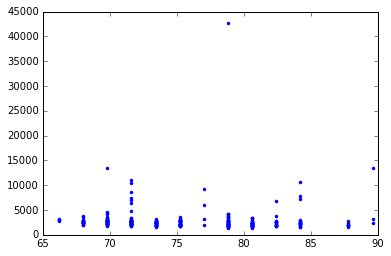

In [282]:
# plot to examine relationship between temperature and air quality
pl.plot(wmerge['TemperatureF'], wmerge['particles'], '.')

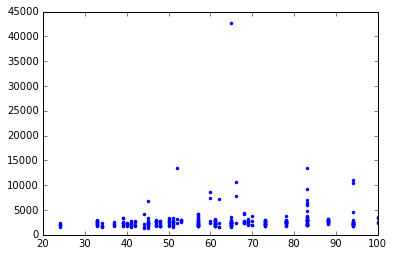

In [280]:
# plot to examine relationship between humidity and air quality
pl.plot(wmerge['Humidity'], wmerge['particles'], '.')

In [288]:
# looking at impact of humidity and temperature together on air quality
reg = smf.ols(formula = 'particles ~ Humidity + TemperatureF', data = wmerge).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              particles   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     3.963
Date:                Sun, 16 Apr 2017   Prob (F-statistic):             0.0201
Time:                        22:38:24   Log-Likelihood:                -2676.4
No. Observations:                 286   AIC:                             5359.
Df Residuals:                     283   BIC:                             5370.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept    -6318.7518   3903.059     -1.619      0.107      -1.4e+04  1363.960
Humidity        36.2287     12.891      2.810      0.005        10.855    61.602
TemperatureF    92.0175     43.268      2.127      0.034         6.850   177.185
==============================================================================
Omnibus:                      514.738   Durbin-Watson:                   1.899
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           218681.561
Skew:                          10.213   Prob(JB):                         0.00
Kurtosis:                     136.917   Cond. No.                     2.31e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.31e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The r-squared value is low, so not much of the variance in the data is being explained by the OLS model. Humidity, with a lower p-value, has somewhat more significance than temperature.

### Land Use and Location

I'll comment on land use and location here since I wasn't able to bring in the PLUTO data (as explained above). Constantine told us a few things that affect air quality in Red Hook:
- it's downwind of Manhattan and Jersey City
- it's low-lying
- there are cement plants in the area
- and there may have been something about barometric pressure keeping particulates in place there

## For noise, you should analyze the relationship (if any) between noise level readings, 311 complaints about noise, and land use.

In [295]:
# 311 data previously filtered for only noise complaints between relevant dates in zip code 11231 and then downloaded
data311 = pd.read_csv('311_Service_Requests.csv')
data311.drop([u'Cross Street 1', u'Agency Name', u'Street Name',
       u'Cross Street 2', u'Intersection Street 1', u'Intersection Street 2',
       u'Address Type', u'Landmark', u'Facility Type', u'Status',
       u'Due Date', u'Resolution Description',
       u'Resolution Action Updated Date', u'Community Board', u'Borough',
       u'X Coordinate (State Plane)', u'Y Coordinate (State Plane)',
       u'Park Facility Name', u'Park Borough', u'School Name',
       u'School Number', u'School Region', u'School Code',
       u'School Phone Number', u'School Address', u'School City',
       u'School State', u'School Zip', u'School Not Found',
       u'School or Citywide Complaint', u'Vehicle Type',
       u'Taxi Company Borough', u'Taxi Pick Up Location',
       u'Bridge Highway Name', u'Bridge Highway Direction', u'Road Ramp',
       u'Bridge Highway Segment', u'Garage Lot Name', u'Ferry Direction',
       u'Ferry Terminal Name', u'Latitude', u'Longitude', u'Location'], axis=1, inplace=True)
data311.head()

,Unique Key,Created Date,Closed Date,Agency,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,City
0,33648024,06/20/2016 10:04:21 PM,06/20/2016 11:12:32 PM,NYPD,Noise - Residential,Loud Music/Party,Residential Building/House,11231,70 BUSH STREET,BROOKLYN
1,33654645,06/21/2016 02:14:50 PM,06/21/2016 03:07:37 PM,NYPD,Noise - Commercial,Banging/Pounding,Store/Commercial,11231,175 DIKEMAN STREET,BROOKLYN
2,33655882,06/21/2016 01:39:00 PM,06/29/2016 04:15:00 PM,DEP,Noise,Noise: Alarms (NR3),NaN,11231,39 COFFEY STREET,BROOKLYN
3,33663657,06/22/2016 08:10:56 AM,06/22/2016 09:04:06 AM,NYPD,Noise - Commercial,Banging/Pounding,Club/Bar/Restaurant,11231,SMITH STREET,BROOKLYN
4,33668352,06/23/2016 10:40:46 AM,06/23/2016 12:07:33 PM,NYPD,Noise - Commercial,Car/Truck Horn,Store/Commercial,11231,175 DIKEMAN STREET,BROOKLYN


In [ ]:
# creating a dataframe of RHI's upper sound outliers; this was chosen because only the rooftops had outliers,
# and the other roof had many more, so RHI's two data points are easier to analyze (as a start)
RHIstd = spl_0['sound'].std()
RHImean = spl_0['sound'].mean()
RHIoutliers = spl_0[spl_0['sound'] > (RHImean + 2 * RHIstd)]

In [440]:
# creating a column that's just date and time, because we can't expect the complaint to necessary happen at the exact
# moment of the sound outlier observed by the sensor
RHIoutliers['date'] = RHIoutliers['dt'].map(lambda x: str(x)[:-9])
RHIoutliers['date'] = pd.to_datetime(RHIoutliers['date'])
RHIoutliers.head()

/Users/adriandahlin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/adriandahlin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,dt,sensor,light,particles,sound,date
dt,,,,,,
2016-06-22 12:00:00,2016-06-22 12:00:00,sensor_0,44426.625,2786.37125,88.647875,2016-06-22
2016-07-09 04:00:00,2016-07-09 04:00:00,sensor_0,20956.000,3919.89000,87.064250,2016-07-09


In [ ]:
# creating the same date-only column in the 311 data
data311['date'] = data311['Created Date'].map(lambda x: str(x)[:-12])
data311['date'] = pd.to_datetime(data311['date'])

In [450]:
# pulling out the 311 noise complaints from the two relevant days
reduced311a = data311[data311['date'] == '2016-06-22']
reduced311b = data311[data311['date'] == '2016-07-09']

frames = [reduced311a, reduced311b]

reduced311 = pd.concat(frames)
reduced311

,Unique Key,Created Date,Closed Date,Agency,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,City,date
3,33663657,06/22/2016 08:10:56 AM,06/22/2016 09:04:06 AM,NYPD,Noise - Commercial,Banging/Pounding,Club/Bar/Restaurant,11231,SMITH STREET,BROOKLYN,2016-06-22
82,33792559,07/09/2016 12:52:38 AM,07/09/2016 01:35:24 AM,NYPD,Noise - Residential,Banging/Pounding,Residential Building/House,11231,442 COLUMBIA STREET,BROOKLYN,2016-07-09
83,33798185,07/09/2016 03:52:40 PM,07/09/2016 07:21:40 PM,NYPD,Noise - Residential,Banging/Pounding,Residential Building/House,11231,38 BUSH STREET,BROOKLYN,2016-07-09
84,33801389,07/09/2016 03:54:43 PM,07/09/2016 07:21:38 PM,NYPD,Noise - Residential,Banging/Pounding,Residential Building/House,11231,428 COLUMBIA STREET,BROOKLYN,2016-07-09
85,33801390,07/09/2016 03:48:31 PM,07/09/2016 07:21:40 PM,NYPD,Noise - Residential,Banging/Pounding,Residential Building/House,11231,80 DWIGHT STREET,BROOKLYN,2016-07-09
105,33798652,07/09/2016 09:35:00 AM,07/16/2016 01:00:00 PM,DEP,Noise,Noise: Construction Before/After Hours (NM1),NaN,11231,93 DOUGLASS STREET,BROOKLYN,2016-07-09
106,33802604,07/09/2016 11:09:00 AM,07/16/2016 12:00:00 PM,DEP,Noise,Noise: Construction Before/After Hours (NM1),NaN,11231,25 TOMPKINS PLACE,BROOKLYN,2016-07-09
114,33799451,07/09/2016 05:26:00 PM,07/16/2016 02:30:00 PM,DEP,Noise,Noise: Construction Before/After Hours (NM1),NaN,11231,93 DOUGLASS STREET,BROOKLYN,2016-07-09


There's no complaint in the 311 data that occurs at or shortly after the spike in sound at noon on June 22.

There are two complaints about construction noise on the morning of  July 9, which could potentially be where the spike at 4am came from. However, 93 Douglass St and 25 Tompkins Pl are not near RHI. See that on a map: https://www.google.com/maps/dir/25+Tompkins+Pl,+Brooklyn,+NY+11231/767+Hicks+St,+Brooklyn,+NY+11231/@40.6814228,-74.0091301,15z/data=!3m1!4b1!4m13!4m12!1m5!1m1!1s0x89c25a5a7b50ecbb:0x88ebfae3e17524ba!2m2!1d-73.995451!2d40.684855!1m5!1m1!1s0x89c25af51cf690bb:0x19c586d0602c365b!2m2!1d-74.0044647!2d40.6767795.

No insights about where the sound outliers at the RHI roof came from can be gained from this analysis.